## Entrainement de plusieurs models et plusieurs dataset au choix




## Import Python Module

In [1]:
#gestion fichier modeles pythons
import os , sys            
workpath = sys.path[0]

sys.path.append(f'{workpath}\fidle-env\lib\site-packages')

#modules utilitaires
import random as r
import numpy as np
import time 
import json
import fidle
import fidle.pwk as pwk   
#traitement image
import matplotlib.pyplot as plt   
from skimage import io 
import pandas as pd
import glob
from pathlib import Path
from IPython.display import display, Markdown

#module IA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import activations



## les diffs choix de dataset.

In [2]:
datapath = f'{workpath}\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_64_equilibre'
descri_datapath = [datapath, 'img_64']
run_dir="E:\INSA-cour\A4A\Projet_multi\work-dictory\\trained_model\model_64_equilibre"
fidle.utils.mkdir(run_dir)

## Parameters for CNN and DNN

In [3]:
#pourcentage du dataset à load
scale = 0.5  

batch_size    = 64
epochs        = 25
fit_verbosity = 1

index_to_class = ["CUBO","DEC","FCC","FCC-sphere","HCP-sphere","ICO","MnBeta_sphere","OH","RTD","BCC","DODECA"]

## Dataset loading

In [4]:
def read_dataset (filepath : str):
    """entrée : chemin vers le dossier contenant la BDD
    sortie : listes des images et leur classes respectives, mis à l'échelle (scale) et mélangées"""
    
    """
    au lieu d'avoir un set de training 80%, un set de test 20%, j'ai appliqué ici un strategie conseillé si on a beacoup de donnee, 
    un training set 70%, un test set pour validation 15%, et un test final set 15% pour faire l'evaluation. Vu que le test set a une effet parasit sur le training set
    """
    
    L = os.listdir(filepath)   #liste contenenant le nom (en .jpg) de toutes les images
    nb_files = len(L)
    nb_files2load = round(nb_files*scale)
    size = np.shape(io.imread(f'{filepath}/{L[0]}' , as_gray = True))
    
    #initialisation listes sortie
    img = np.zeros ( (nb_files2load , size[0] , size[1]) , dtype = np.float16 )
    ID  = np.zeros ( nb_files2load , dtype = np.int8)
   
    for i in range (nb_files2load):
        
        random_index = r.randint(0 , nb_files - i - 1)
        img[i] = io.imread (f'{filepath}/{L[random_index]}',as_gray = True)
        ID [i] = int (L[random_index][:3]) - 1
        L.pop(random_index)
        
    N = len(img)
    nb_img = N
    a = N*0.7
    b = N*0.85
    img_train = img[0:round(a)]
    img_test  = img[round(a):round(b)]
    img_test_final = img[round(b):]
    ID_train = ID[0:round(a)]
    ID_test  = ID[round(a):round(b)]  
    ID_test_final = ID[round(b):]
    
        
    return img_train,img_test,ID_train,ID_test,nb_img, img_test_final, ID_test_final


## Models creations

In [ ]:
## un seul modele qui me semble le mieux

In [ ]:
def create_model2_700(lx,ly): # 2 couche de dense de 700 neurons
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,1)))
    model.add( keras.layers.MaxPooling2D((3, 3)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( layers.Dense(700))
    model.add( layers.Dense(700))
    model.add( layers.Activation(activations.tanh)) 
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(11, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    code_model='2_700'
    model_name = 'e'+str(epochs)+'bs'+str(batch_size)+'sc'+str(scale)+'code'+str(code_model)
    return model, model_name, code_model

## qq variable a entrer dans les foncitons suivants (n'oublier pas de changer tag_id si on change de modele, dataset, etc.)

In [7]:
# les entree pour le dataset 64
datasets = [descri_datapath]
with_datagen  = False
t = pwk.tag_now()
tag_id = f'foncs_acti_{str(t)}' #si on faire un autre execution de script, n'oublie pas de changer le tag_id comme "fonc_acti_<un date>" ou "nombre_de_couche", etc.
#tag_id = 'optimizer_08_03_v2'
#en fait, on peut lance plusieurs fois les meme entrainements, pour surperposer les courbes sur le meme schema dans tensorboard.
models = ['create_model1','create_model1_DNNsigmod','create_model1_DNNtanh','create_model1_DNNsoftsign','create_model1_DNNelu','create_model1_DNNselu','create_model1_DNNsoftplus']
#models = ['create_model1_100','create_model2_100','create_model3_100']
#models = ['create_model1_DNNtanh_adam','create_model1_DNNtanh_Adamax','create_model1_DNNtanh_Nadam','create_model1_DNNtanh_RMSprop']
#models = ['create_model2_100','create_model2_300','create_model2_500','create_model2_700','create_model2_900','create_model2_1000']
#models = ['m2_2000_dr_01','m2_2000_dr_02','m2_2000_dr_03','m2_2000_dr_04','m2_2000_dr_05']

## Multiple datasets, multiple models ;-)

In [13]:
def multi_run(datasets, models, datagen=None,
              scale=1, batch_size=64, epochs=16, 
              fit_verbosity=0, tag_id='last'):
    """
    Launches a dataset-model combination
    args:
        enhanced_dir   : Directory of the enhanced datasets
        datasets       : List of dataset (whitout .h5)
        models         : List of model like { "model name":get_model(), ...}
        datagen        : Data generator or None (None)
        scale          : % of dataset to use.  1 mean all. (1)
        batch_size     : Batch size (64)
        epochs         : Number of epochs (16)
        fit_verbosity  : Verbose level (0)
        tag_id         : postfix for report, logs and models dir (_last)
    return:
        report        : Report as a dict for Pandas.
    """  
    # ---- Logs and models dir
    #
    os.makedirs(f'{run_dir}/logs_{tag_id}',   mode=0o750, exist_ok=True)
    os.makedirs(f'{run_dir}/models_{tag_id}', mode=0o750, exist_ok=True)
    
    # ---- Columns of output
    #
    output={}
    output['Dataset'] = []
    output['Size']    = []
    
    for m in models:
        output[m+'_Accuracy'] = []
        output[m+'_Duration'] = []
        output[m+'_loss'] = []
    # ---- Let's go
    #
    for d_name in datasets:
        print("\nDataset : ",d_name[0])
        
        # ---- Read dataset
        img_train,img_test,ID_train,ID_test, d_size, img_test_final, ID_test_final = read_dataset(d_name[0])
        imgs = [img_train,img_test,ID_train,ID_test, img_test_final, ID_test_final]
        d_name = d_name[1]
        output['Dataset'].append(d_name)
        output['Size'].append(d_size)
        print(len(img_train))
        print(len(ID_train))
        # ---- Rescale c'est pas vraiment necessaire
        ##img_train,ID_train,img_test,ID_test = pwk.rescale_dataset(img_train,ID_train,img_test,ID_test, scale=scale)
        
        # ---- Get the shape
        (n,lx,ly) = img_train.shape

        # ---- For each model
        for m_function in models:
            
            # ---- get model
            try:
                # ---- get function by name
                m = m_function
                m_function=globals()[m_function]
                model, m_name, code_model=m_function(lx,ly)
                
                print("    Run model {}  : ".format(code_model), end='')
                # ---- Compile it # si on ne compare pas de diffs optimizer on ajoute ce ligne.
                if tag_id[:6] != 'opitmizer':
                    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                # ---- Callbacks tensorboard
                log_dir = f'{run_dir}/logs_{tag_id}/tb_{d_name}_{m_name}'
                tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
                # ---- Callbacks bestmodel
                save_dir = f'{run_dir}/models_{tag_id}/model_{d_name}_{m_name}.h5'
                bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)
                # ---- Train
                start_time = time.time()
                if datagen==None:
                    # ---- No data augmentation (datagen=None) --------------------------------------
                    history = model.fit(img_train, ID_train,
                                        batch_size      = batch_size,
                                        epochs          = epochs,
                                        verbose         = fit_verbosity,
                                        validation_data = (img_test, ID_test),
                                        callbacks       = [tensorboard_callback, bestmodel_callback])
                else:
                    # ---- Data augmentation (datagen given) ----------------------------------------
                    datagen.fit(x_train)
                    history = model.fit(datagen.flow(img_train, ID_train, batch_size=batch_size),
                                        steps_per_epoch = int(len(img_train)/batch_size),
                                        epochs          = epochs,
                                        verbose         = fit_verbosity,
                                        validation_data = (img_test, ID_test),
                                        callbacks       = [tensorboard_callback, bestmodel_callback])
                
                
                
                # ---- Result
                end_time = time.time()
                duration = end_time-start_time
                # ---- Evaluation final
                loss, accuracy = model.evaluate(img_test_final, ID_test_final, batch_size=batch_size)
                accuracy = accuracy * 100
                #accuracy = max(history.history["val_accuracy"])*100
                #
                output[m+'_Accuracy'].append(accuracy)
                output[m+'_Duration'].append(duration)
                output[m+'_loss'].append(loss)
                print(f"Accuracy={accuracy: 7.2f}    Duration={duration: 7.2f}")
            except:
                raise
                output[m+'_Accuracy'].append('0')
                output[m+'_Duration'].append('999')
                print('-')
            
    return output, imgs

## run

In [14]:
pwk.chrono_start()

print('\n---- Run','-'*50)


# ---- Data augmentation or not
#
if with_datagen :
    datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                                                           featurewise_std_normalization=False,
                                                           width_shift_range=0.1,
                                                           height_shift_range=0.1,
                                                           zoom_range=0.2,
                                                           shear_range=0.1,
                                                           rotation_range=10.)
else:
    datagen=None
    
# ---- Run
#
output, imgs = multi_run(datasets, 
                   models,
                   datagen       = datagen,
                   scale         = scale,
                   batch_size    = batch_size,
                   epochs        = epochs,
                   fit_verbosity = fit_verbosity,
                   tag_id        = tag_id)

# ---- Save report
#
report={}
report['output']=output
report['description'] = f'scale={scale} batch_size={batch_size} epochs={epochs} data_aug={with_datagen}'

report_name=f'{run_dir}/report_{tag_id}.json'

with open(report_name, 'w') as file:
    json.dump(report, file, indent=4)

print('\nReport saved as ',report_name)

pwk.chrono_show()
print('-'*59)



---- Run --------------------------------------------------

Dataset :  E:\INSA-cour\A4A\Projet_multi\work-dictory\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_64_equilibre
7015
7015
    Run model 1  : Epoch 1/25
110/110 [==============================] - 14s 122ms/step - loss: 2.2517 - accuracy: 0.1622 - val_loss: 1.9476 - val_accuracy: 0.2673
Epoch 2/25
110/110 [==============================] - 13s 118ms/step - loss: 1.7424 - accuracy: 0.3234 - val_loss: 1.4309 - val_accuracy: 0.4322
Epoch 3/25
110/110 [==============================] - 13s 120ms/step - loss: 1.3213 - accuracy: 0.4744 - val_loss: 1.0068 - val_accuracy: 0.6370
Epoch 4/25
110/110 [==============================] - 13s 118ms/step - loss: 1.0292 - accuracy: 0.5792 - val_loss: 0.7580 - val_accuracy: 0.7447
Epoch 5/25
110/110 [==============================] - 13s 120ms/step - loss: 0.8954 - accuracy: 0.6488 - val_loss: 0.7734 - val_accuracy: 0.7008
Epoch 6/25
110/110 [==============================] - 13

## show report

In [15]:
report_dir = run_dir

In [16]:
def highlight_max(s):
    is_max = (s == s.max())
    return ['background-color: yellow' if v else '' for v in is_max]

def show_report(file):
    # ---- Read json file
    with open(file) as infile:
        dict_report = json.load( infile )
    output      = dict_report['output']
    description = dict_report['description']
    # ---- about
    pwk.subtitle(f'Report : {Path(file).stem}')
    print(    "Desc.  : ",description,'\n')
    # ---- Create a pandas
    report       = pd.DataFrame (output)
    col_accuracy = [ c for c in output.keys() if c.endswith('Accuracy')]
    col_duration = [ c for c in output.keys() if c.endswith('Duration')]
    # ---- Build formats
    lambda_acc = lambda x : '{:.2f} %'.format(x) if (isinstance(x, float)) else '{:}'.format(x)
    lambda_dur = lambda x : '{:.1f} s'.format(x) if (isinstance(x, float)) else '{:}'.format(x)
    formats = {'Size':'{:.2f} Mo'}
    for c in col_accuracy:   
        formats[c]=lambda_acc
    for c in col_duration:
        formats[c]=lambda_dur
    t=report.style.highlight_max(subset=col_accuracy).format(formats).hide_index()
    display(t)

## Step 3 - Reports display

In [17]:
#for file in glob.glob(f'{report_dir}/*.json'):
file = report_name
show_report(file)


<br>**Report : report_foncs_acti_2023-03-19_15h03m36s**

Desc.  :  scale=0.5 batch_size=64 epochs=25 data_aug=False 



F:\Temp\ipykernel_18788\2258343395.py:26: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  t=report.style.highlight_max(subset=col_accuracy).format(formats).hide_index()


Dataset,Size,create_model1_Accuracy,create_model1_Duration,create_model1_loss,create_model1_DNNsigmod_Accuracy,create_model1_DNNsigmod_Duration,create_model1_DNNsigmod_loss,create_model1_DNNtanh_Accuracy,create_model1_DNNtanh_Duration,create_model1_DNNtanh_loss,create_model1_DNNsoftsign_Accuracy,create_model1_DNNsoftsign_Duration,create_model1_DNNsoftsign_loss,create_model1_DNNelu_Accuracy,create_model1_DNNelu_Duration,create_model1_DNNelu_loss,create_model1_DNNselu_Accuracy,create_model1_DNNselu_Duration,create_model1_DNNselu_loss,create_model1_DNNsoftplus_Accuracy,create_model1_DNNsoftplus_Duration,create_model1_DNNsoftplus_loss
img_64,10022.00 Mo,92.75 %,320.5 s,0.188452,90.29 %,335.9 s,0.254677,89.02 %,335.6 s,0.283108,91.35 %,339.0 s,0.235724,93.01 %,348.0 s,0.196369,89.09 %,334.5 s,0.280198,89.82 %,318.3 s,0.249344


## model evaluate matrix de confusion 

In [18]:
models = os.listdir(f'{run_dir}\models_{tag_id}')
print(models) # tu choisis un des modeles listés et le mettre dans le variable model_choisit au dessous.

['model_img_64_e25bs64sc0.5code1.h5', 'model_img_64_e25bs64sc0.5code1_DNNelu.h5', 'model_img_64_e25bs64sc0.5code1_DNNselu.h5', 'model_img_64_e25bs64sc0.5code1_DNNsigmod.h5', 'model_img_64_e25bs64sc0.5code1_DNNsoftplus.h5', 'model_img_64_e25bs64sc0.5code1_DNNsoftsign.h5', 'model_img_64_e25bs64sc0.5code1_DNNtanh.h5']


In [48]:
model_choisit = 'model_img_64_e25bs64sc0.5code1_DNNsoftplus.h5'
model_choisit = f'{run_dir}\models_{tag_id}\{model_choisit}'
model_evaluated = tf.keras.models.load_model(model_choisit) #load ton model choisite, tu peux aussi copie coller la chemin absolute ou le model est stocké

In [49]:
model_evaluated.summary() # son structure

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 20, 20, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 9, 9, 64)         0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 9, 9, 64)         

In [50]:
img_test_final = imgs[5]
ID_test_final = imgs[6]
score = model_evaluated.evaluate(img_test_final, ID_test_final, verbose=0) #evaluation de ce models

print('Test loss     :', score[0])
print('Test accuracy :', score[1])

Test loss     : 0.24934372305870056
Test accuracy : 0.8982036113739014


## erreurs

47/47 [==============================] - 1s 14ms/step


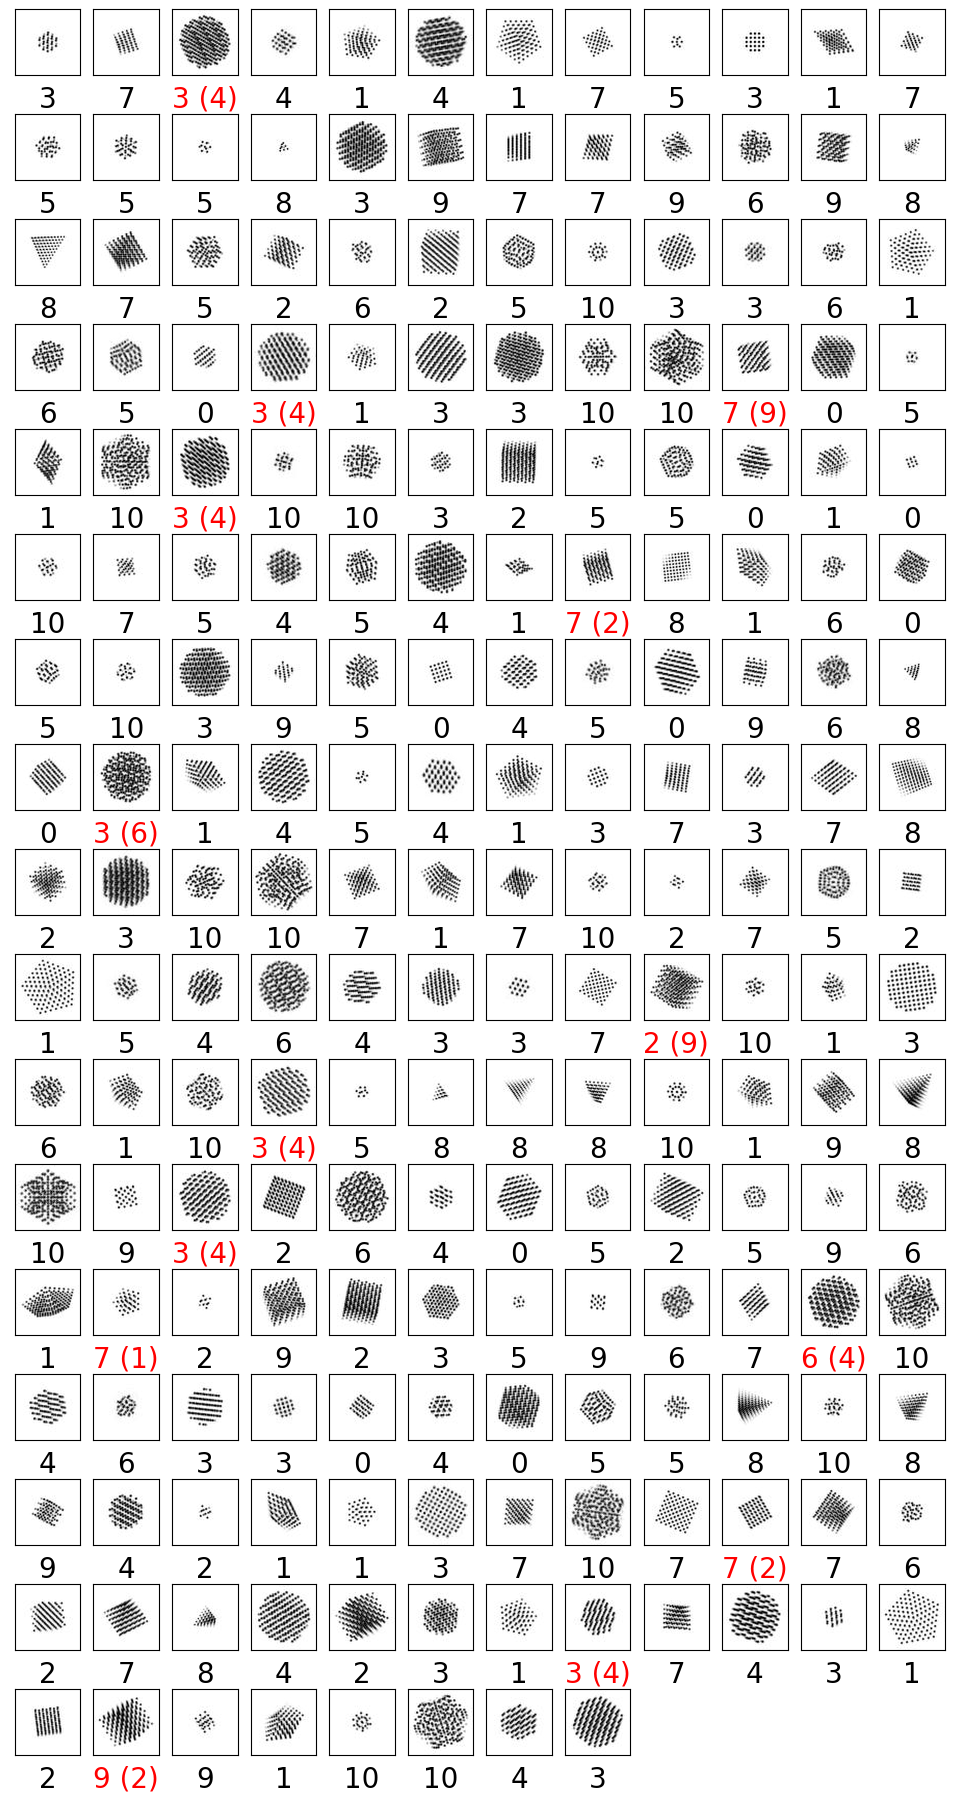

In [51]:
y_sigmoid = model_evaluated.predict(img_test_final)
ID_pred    = np.argmax(y_sigmoid, axis=-1)

pwk.plot_images(img_test_final, ID_test_final, range(0,200), columns=12, x_size=1, y_size=1, y_pred=ID_pred, save_as='04-predictions')

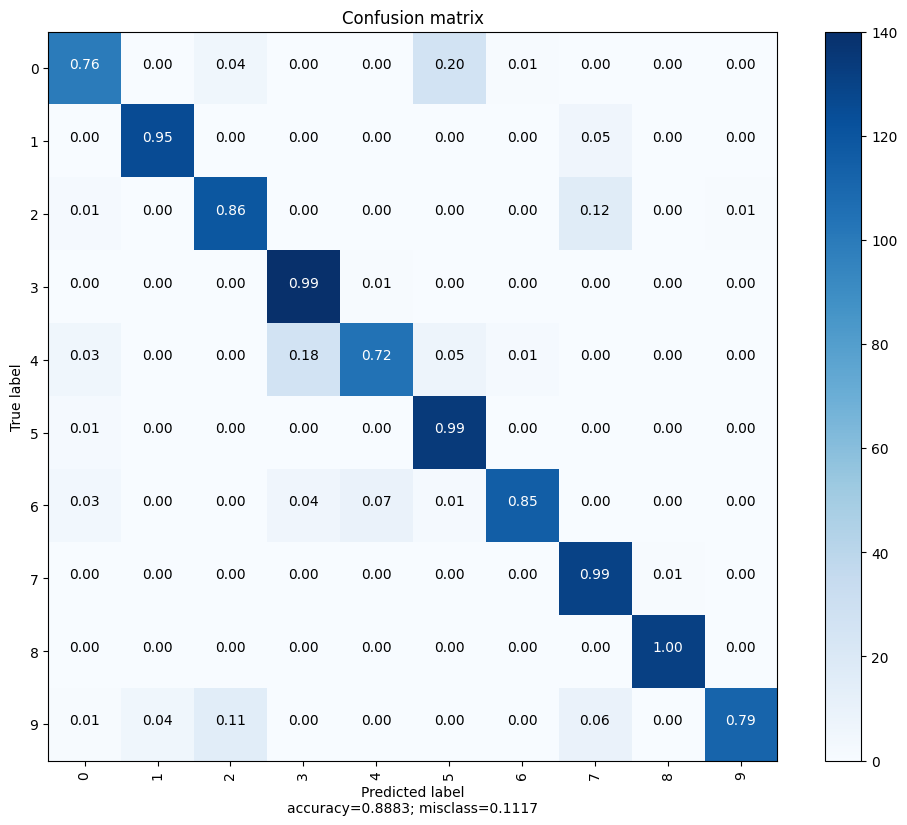

In [52]:
pwk.plot_confusion_matrix(ID_test_final,ID_pred,range(10),normalize=True, save_as='06-confusion-matrix')